In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pygam import LinearGAM, s, te, f

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [2]:
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target']
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
feature_rename = {'age': 'Age',
                  'sex': 'Sex',
                  'bmi': 'BMI',
                  'bp': 'BP',
                  's1': 'Total Cholesterol',
                  's2': 'LDL',
                  's3': 'HDL',
                  's4': 'Thyroid',
                  's5': 'Glaucoma',
                  's6': 'Glucose'}
df_data = pd.DataFrame(X, 
                       columns=diabetes['feature_names'])
df_data.rename(columns=feature_rename, inplace=True)
feature_names = list(df_data.columns.values)
df_data['target'] = y

In [4]:
df_data.head()

,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,Thyroid,Glaucoma,Glucose,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


# Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.shape

(353, 10)

In [7]:
X_test.shape

(89, 10)

In [8]:
y_train.shape

(353,)

In [9]:
y_test.shape

(89,)

# Train GAM

In [10]:
gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9),
                n_splines=35)

In [11]:
# gam.fit(X_train, y_train)
gam.gridsearch(X_train, y_train)

100% |########################################################################|


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + intercept,
   tol=0.0001, verbose=False)

In [12]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.7114
Link Function:                     IdentityLink Log Likelihood:                                  -3142.722
Number of Samples:                          353 AIC:                                             6342.8668
                                                AICc:                                            6348.1441
                                                GCV:                                             3411.4587
                                                Scale:                                            2933.054
                                                Pseudo R-Squared:                                   0.5552
Feature Function                  Lam

/Users/ajay/opt/anaconda3/envs/interpretable-ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [13]:
dump(gam, 'models/chapter_02_gam.joblib')

['models/chapter_02_gam.joblib']

# Evaluate GAM

In [14]:
gam = load('models/chapter_02_gam.joblib')

In [15]:
y_pred = gam.predict(X_test)

In [16]:
mae = np.mean(np.abs(y_test - y_pred))
print(mae)

41.383326521833105


In [17]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

52.22991055273535


In [18]:
mape = np.mean(np.abs(y_test - y_pred) / y_test) * 100
print(mape)

35.674305762857074


# Interpret GAM

In [19]:
print(feature_names)

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


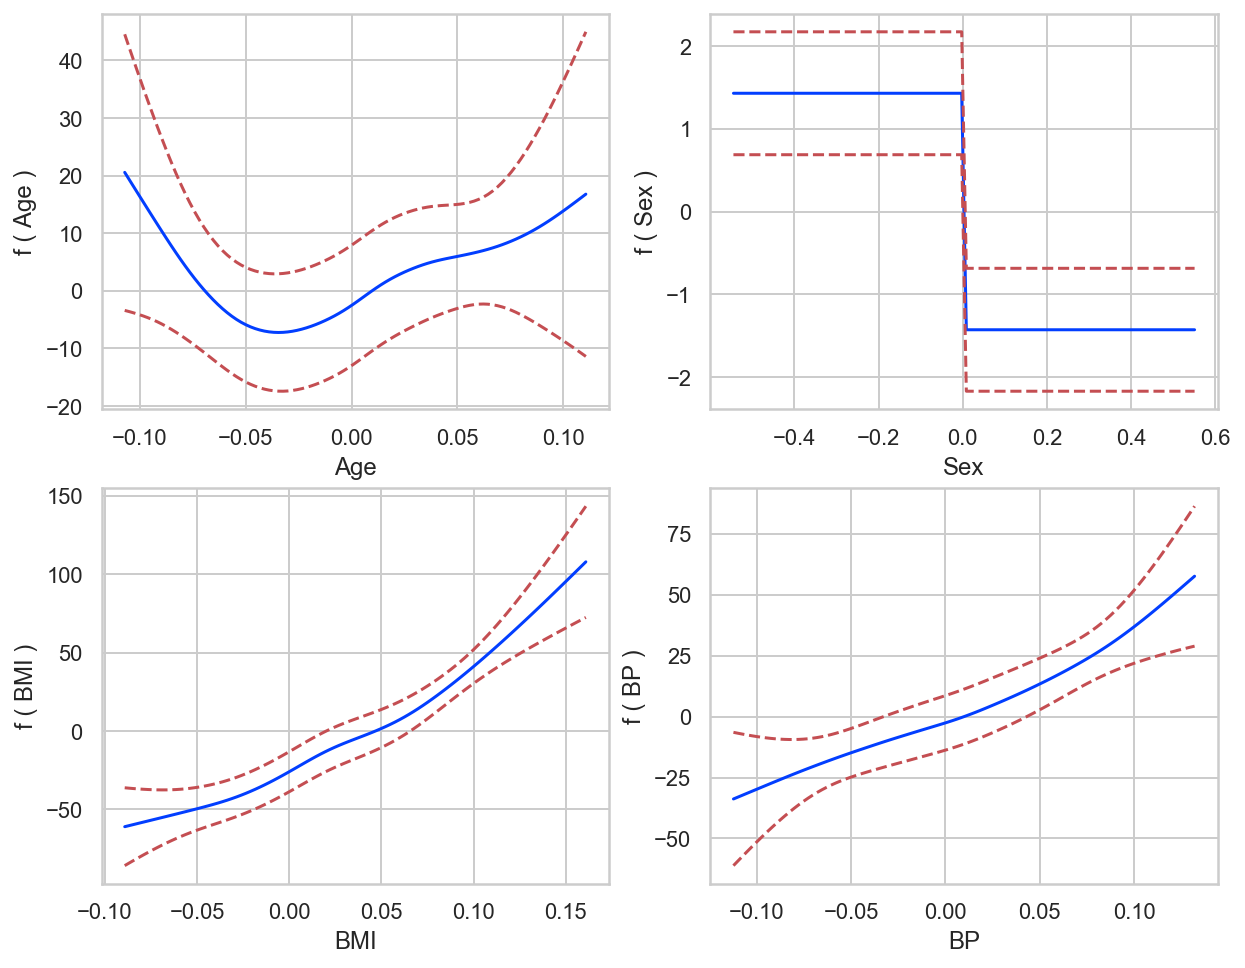

In [20]:
grid_locs1 = [(0, 0), (0, 1),
              (1, 0), (1, 1)]
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for i, feature in enumerate(feature_names[:4]):
    gl = grid_locs1[i]
    XX = gam.generate_X_grid(term=i)
    ax[gl[0], gl[1]].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax[gl[0], gl[1]].plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax[gl[0], gl[1]].set_xlabel('%s' % feature)
    ax[gl[0], gl[1]].set_ylabel('f ( %s )' % feature)
fig.savefig('images/chapter_02_gam_pdp_first_four_features.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_02_gam_pdp_first_four_features.pdf', format='pdf', dpi=300, bbox_inches='tight');

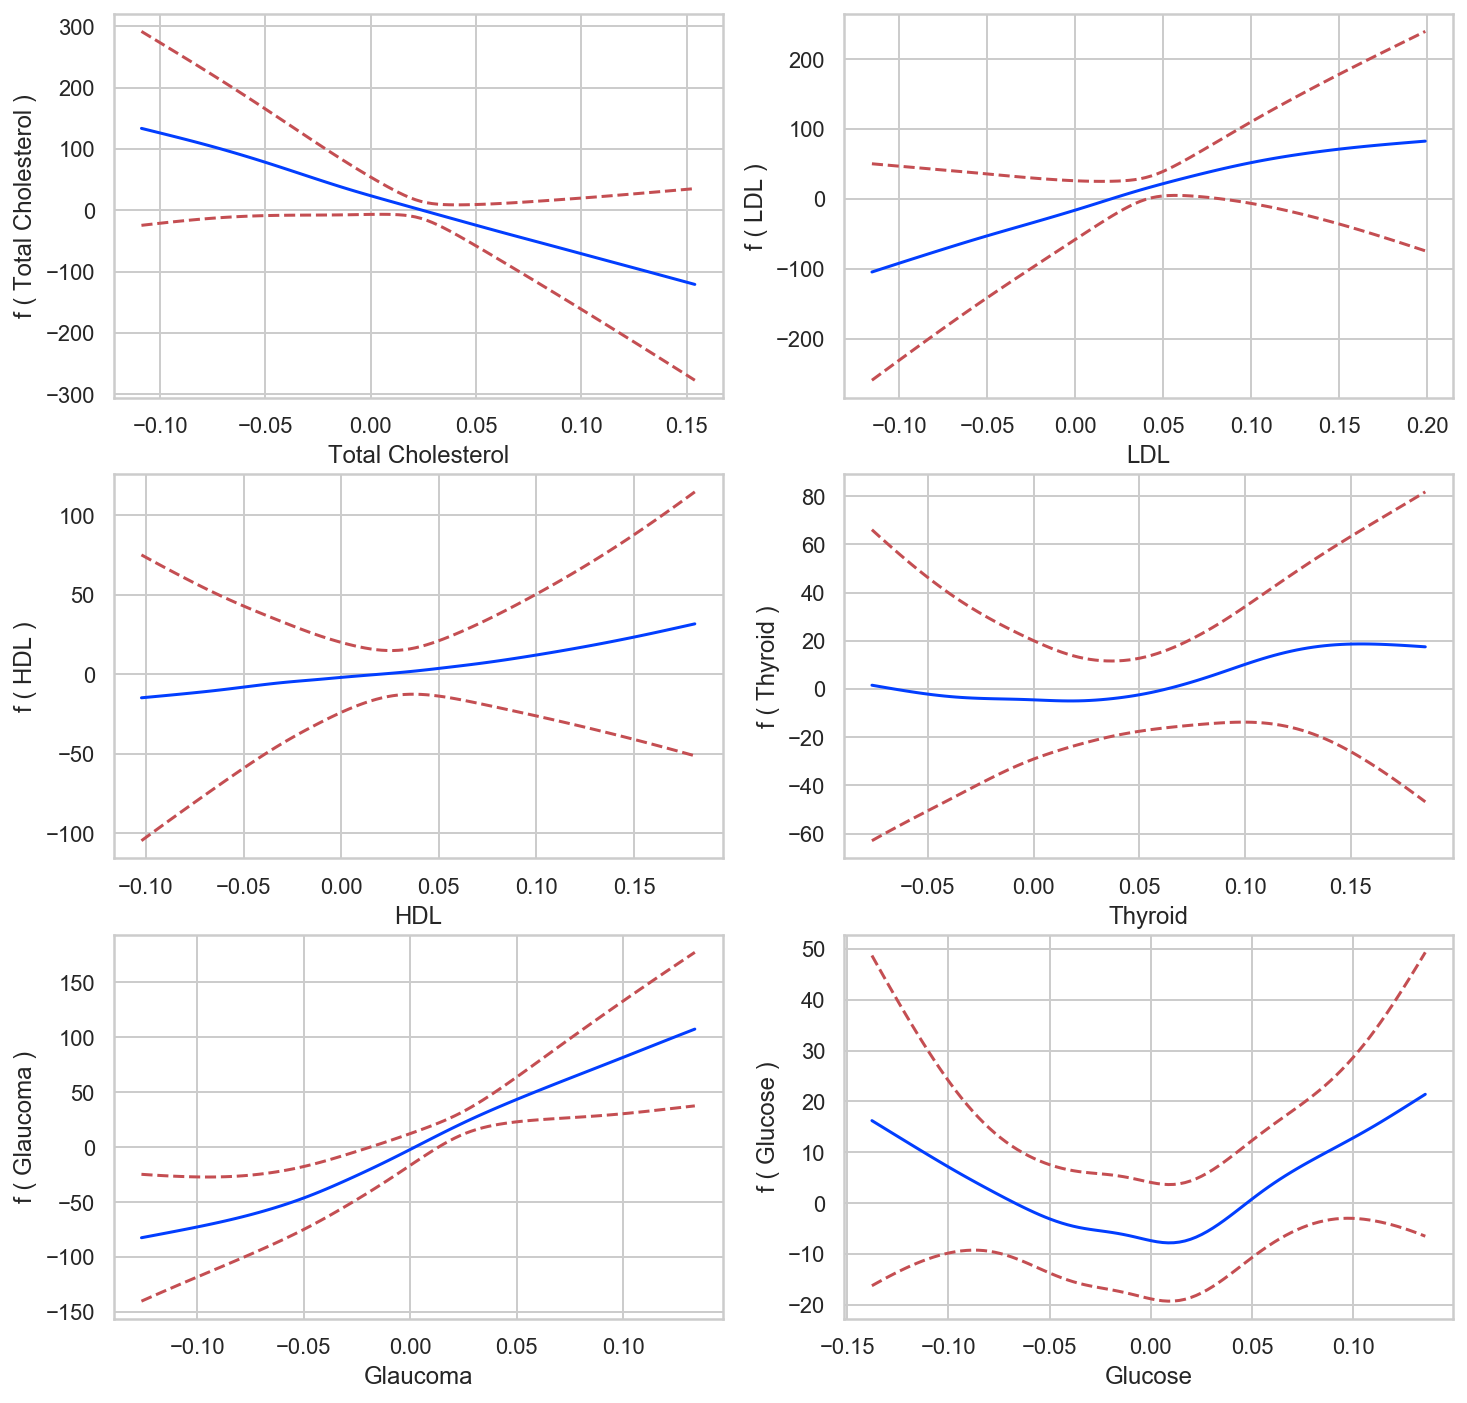

In [21]:
grid_locs2 = [(0, 0), (0, 1),
             (1, 0), (1, 1),
             (2, 0), (2, 1)]
fig2, ax2 = plt.subplots(3, 2, figsize=(12, 12))
for i, feature in enumerate(feature_names[4:]):
    idx = i + 4
    gl = grid_locs2[i]
    XX = gam.generate_X_grid(term=idx)
    ax2[gl[0], gl[1]].plot(XX[:, idx], gam.partial_dependence(term=idx, X=XX))
    ax2[gl[0], gl[1]].plot(XX[:, idx], gam.partial_dependence(term=idx, X=XX, width=.95)[1], c='r', ls='--')
    ax2[gl[0], gl[1]].set_xlabel('%s' % feature)
    ax2[gl[0], gl[1]].set_ylabel('f ( %s )' % feature)
fig2.savefig('images/chapter_02_gam_pdp_blood_serum_features.png', dpi=300, bbox_inches='tight');
fig2.savefig('images/chapter_02_gam_pdp_blood_serum_features.pdf', format='pdf', dpi=300, bbox_inches='tight');